# Projective Complex Line in $\mathbb{CP}^1$ as compactification

In [1]:
import numpy as np
import matplotlib.pyplot as plt


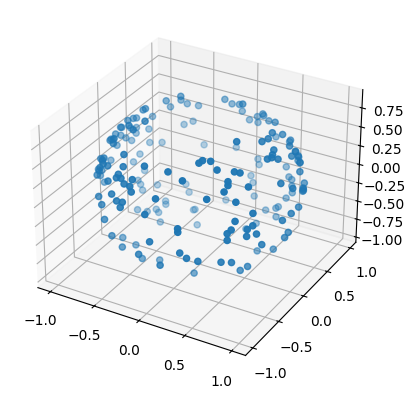

In [ ]:

def stereographic_projection(z):
    x = 2*z.real/(1 +abs(z)**2)
    y = 2*z.imag/(1 +abs(z)**2)
    z_s = (abs(z)**2-1) /(1+abs(z)**2)
    return x, y, z_s

points = np.random.randn(200) + 1j*np.random.randn(200)
X, Y, Z = zip(*[stereographic_projection(z) for z in points])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z)
plt.show()


C:\Users\sebas\AppData\Local\Temp\ipykernel_24256\1039610392.py:40: RuntimeWarning: overflow encountered in exp
  resíduo = lap_u + 4 * k * np.exp(u)
C:\Users\sebas\AppData\Local\Temp\ipykernel_24256\1039610392.py:36: RuntimeWarning: invalid value encountered in matmul
  lap_u = -L @ u
C:\Users\sebas\AppData\Local\Temp\ipykernel_24256\1039610392.py:40: RuntimeWarning: invalid value encountered in add
  resíduo = lap_u + 4 * k * np.exp(u)


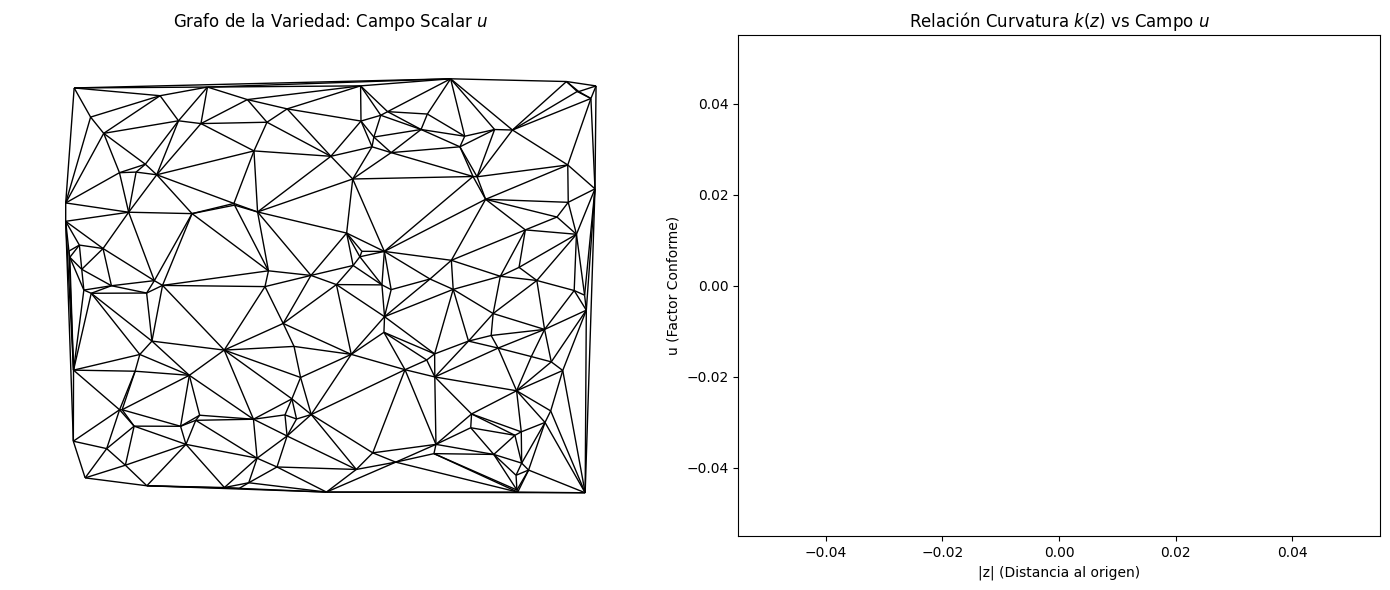

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

def simulate_liouville_graph(n_nodes=100, iterations=500, dt=0.01):
    # 1. Generar puntos aleatorios en el plano complejo (Variedad base)
    points = np.random.rand(n_nodes, 2) * 2 - 1
    z = points[:, 0] + 1j * points[:, 1]
    
    # 2. Crear Grafo Dinámico mediante Triangulación de Delaunay
    tri = Delaunay(points)
    adj = np.zeros((n_nodes, n_nodes))
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                u, v = simplex[i], simplex[j]
                dist = np.linalg.norm(points[u] - points[v])
                adj[u, v] = adj[v, u] = 1 / dist # Peso basado en distancia

    # 3. Definir Curvatura Variable k(z)
    # Ejemplo: Una curvatura que aumenta hacia el centro (efecto lente)
    k = 2.0 * np.exp(-(np.abs(z)**2) / 0.5)
    
    # 4. Inicializar campo escalar u (log-densidad)
    u = np.zeros(n_nodes)
    
    # Matriz Laplaciana del Grafo
    degree = np.diag(np.sum(adj, axis=1))
    L = degree - adj

    # 5. Bucle de Integración (Relajación de la EDP)
    history_u = []
    for _ in range(iterations):
        # Laplaciano discreto: Delta u
        lap_u = -L @ u 
        
        # Ecuación de Liouville: du/dt = Delta u + 4k*exp(u)
        # Buscamos el estado estacionario donde du/dt -> 0
        resíduo = lap_u + 4 * k * np.exp(u)
        u += dt * resíduo 
        
        if _ % 50 == 0:
            history_u.append(u.copy())

    # 6. Visualización
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Grafo con la intensidad del campo u
    nx.draw(nx.from_numpy_array(adj), pos=points, node_size=30, 
            node_color=u, cmap='magma', ax=ax[0])
    ax[0].set_title("Grafo de la Variedad: Campo Scalar $u$")
    
    # Superficie de Curvatura k(z) vs Respuesta u
    ax[1].scatter(np.abs(z), u, c=k, cmap='viridis')
    ax[1].set_xlabel("|z| (Distancia al origen)")
    ax[1].set_ylabel("u (Factor Conforme)")
    ax[1].set_title("Relación Curvatura $k(z)$ vs Campo $u$")
    
    plt.tight_layout()
    plt.show()

# Ejecutar simulación
simulate_liouville_graph(n_nodes=150)


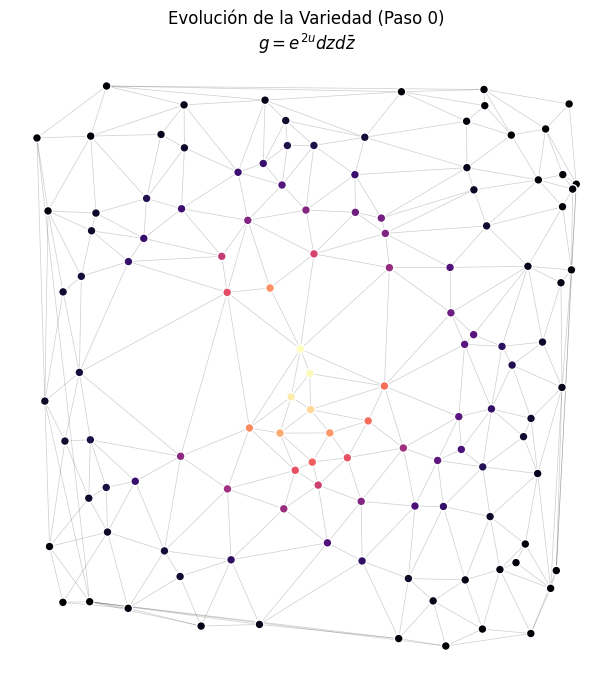

C:\Users\sebas\AppData\Local\Temp\ipykernel_24256\1500274745.py:39: RuntimeWarning: overflow encountered in exp
  resíduo = lap_u + 4 * k * np.exp(u)
C:\Users\sebas\AppData\Local\Temp\ipykernel_24256\1500274745.py:51: RuntimeWarning: overflow encountered in exp
  dist_metrica_deseada = 0.15 * np.exp((u[u_idx] + u[v_idx])/2)
C:\Users\sebas\AppData\Local\Temp\ipykernel_24256\1500274745.py:55: RuntimeWarning: invalid value encountered in multiply
  forces[u_idx] += f_mag * (vec / dist_euclidea)
C:\Users\sebas\AppData\Local\Temp\ipykernel_24256\1500274745.py:56: RuntimeWarning: invalid value encountered in multiply
  forces[v_idx] -= f_mag * (vec / dist_euclidea)


ValueError: Points cannot contain NaN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import networkx as nx

def simulate_dynamic_metric_graph(n_nodes=120, steps=300):
    # 1. Inicialización en el plano complejo
    pos = np.random.rand(n_nodes, 2) * 2 - 1
    u = np.zeros(n_nodes)
    
    # 2. Definir k(z) variable (una montaña de curvatura en el centro)
    def get_k(p):
        r2 = np.sum(p**2, axis=1)
        return 3.0 * np.exp(-r2 / 0.3)

    dt_u = 0.01  # Paso de tiempo para el campo escalar
    dt_p = 0.05  # Paso de tiempo para el movimiento de nodos
    
    plt.ion()
    fig, ax = plt.subplots(figsize=(8, 8))

    for i in range(steps):
        # A. Actualizar la Geometría (Conectividad)
        tri = Delaunay(pos)
        edges = set()
        for simplex in tri.simplices:
            for j in range(3):
                edges.add(tuple(sorted((simplex[j], simplex[(j+1)%3]))))
        
        # Resolverdor para Liouville (Delta u = -4k exp(u)
        # Calculamos Laplaciano de Grafo ad-hoc
        lap_u = np.zeros(n_nodes)
        for u_idx, v_idx in edges:
            diff = u[v_idx] - u[u_idx]
            lap_u[u_idx] += diff
            lap_u[v_idx] -= diff
        
        k = get_k(pos)
        resíduo = lap_u + 4 * k * np.exp(u)
        u += dt_u * resíduo

        # Los nodos se mueven para que su distancia real |p1-p2| 
        # coincida con la distancia métrica deseada L = exp(u)
        forces = np.zeros_like(pos)
        for u_idx, v_idx in edges:
            vec = pos[v_idx] - pos[u_idx]
            dist_euclidea = np.linalg.norm(vec) + 1e-5
            
            # La "distancia natural" en la variedad es proporcional a exp(u)
            dist_metrica_deseada = 0.15 * np.exp((u[u_idx] + u[v_idx])/2)
            
            # Fuerza tipo resorte: F = k * (dist_actual - dist_deseada)
            f_mag = (dist_euclidea - dist_metrica_deseada)
            forces[u_idx] += f_mag * (vec / dist_euclidea)
            forces[v_idx] -= f_mag * (vec / dist_euclidea)
        
        # Aplicar movimiento y mantener dentro de límites
        pos += dt_p * forces
        pos = np.clip(pos, -2, 2)

        # --- D. Visualización en tiempo real ---
        if i % 10 == 0:
            ax.clear()
            # Dibujar aristas
            for u_idx, v_idx in edges:
                p1, p2 = pos[u_idx], pos[v_idx]
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', alpha=0.2, lw=0.5)
            
            # Dibujar nodos coloreados por el factor conforme u
            sc = ax.scatter(pos[:, 0], pos[:, 1], c=u, cmap='magma', s=40, edgecolors='white', zorder=3)
            ax.set_title(f"Evolución de la Variedad (Paso {i})\n$g = e^{{2u}}dzd\\bar{{z}}$")
            ax.set_aspect('equal')
            ax.axis('off')
            plt.pause(0.01)

    plt.ioff()
    plt.show()

simulate_dynamic_metric_graph()


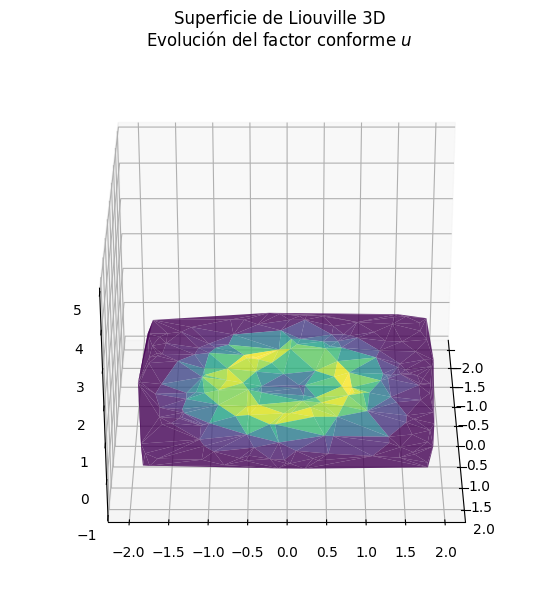

C:\Users\sebas\AppData\Local\Temp\ipykernel_24256\2400892435.py:38: RuntimeWarning: overflow encountered in exp
  u += dt_u * (lap_u + 4 * k_val * np.exp(u))
C:\Users\sebas\AppData\Local\Temp\ipykernel_24256\2400892435.py:38: RuntimeWarning: invalid value encountered in add
  u += dt_u * (lap_u + 4 * k_val * np.exp(u))
C:\Users\sebas\AppData\Local\Temp\ipykernel_24256\2400892435.py:49: RuntimeWarning: invalid value encountered in divide
  pos[n1] += f * (vec / dist)
C:\Users\sebas\AppData\Local\Temp\ipykernel_24256\2400892435.py:50: RuntimeWarning: invalid value encountered in divide
  pos[n2] -= f * (vec / dist)


ValueError: Points cannot contain NaN

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

def simulate_liouville_3d(n_nodes=200, steps=400):
    # 1. Configuración inicial: Puntos en el plano complejo
    pos = np.random.rand(n_nodes, 2) * 4 - 2
    u = np.zeros(n_nodes)
    
    # 2. Curvatura variable k(z): un anillo de curvatura
    def get_k(p):
        r = np.sqrt(np.sum(p**2, axis=1))
        # Curvatura tipo "volcán" para ver formas interesantes
        return 5.0 * np.exp(-(r - 0.8)**2 / 0.2)

    dt_u = 0.005 # Estabilidad para el campo escalar
    
    plt.ion()
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(steps):
        # A. Triangulación dinámica (malla de la variedad)
        tri = Delaunay(pos)
        
        # B. Laplaciano de Grafo para u
        lap_u = np.zeros(n_nodes)
        for simplex in tri.simplices:
            for j in range(3):
                n1, n2 = simplex[j], simplex[(j+1)%3]
                diff = u[n2] - u[n1]
                lap_u[n1] += diff
                lap_u[n2] -= diff
        
        # C. Evolución de la Ecuación de Liouville
        k_val = get_k(pos)
        u += dt_u * (lap_u + 4 * k_val * np.exp(u))
        
        # D. Dinámica de repulsión (métrica g = exp(2u))
        # Los nodos se alejan donde u es alto para aliviar la tensión
        for simplex in tri.simplices:
            for j in range(3):
                n1, n2 = simplex[j], simplex[(j+1)%3]
                vec = pos[n2] - pos[n1]
                dist = np.linalg.norm(vec) + 1e-5
                # Fuerza expansiva basada en el factor conforme
                f = 0.01 * (dist - 0.2 * np.exp(u[n1])) 
                pos[n1] += f * (vec / dist)
                pos[n2] -= f * (vec / dist)

        # E. Renderizado 3D
        if i % 15 == 0:
            ax.clear()
            # Dibujar la malla (trisurf)
            ax.plot_trisurf(pos[:, 0], pos[:, 1], u, triangles=tri.simplices, 
                            cmap='viridis', edgecolor='none', alpha=0.8)
            
            # Ajustes de vista
            ax.set_zlim(-1, 5)
            ax.set_title(f"Superficie de Liouville 3D\nEvolución del factor conforme $u$")
            ax.view_init(elev=30, azim=i/2) # Rotación automática
            plt.pause(0.01)

    plt.ioff()
    plt.show()

simulate_liouville_3d()


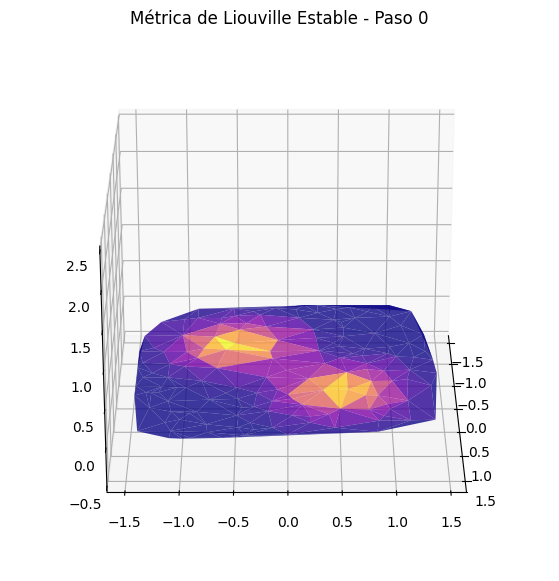

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

def simulate_liouville_stable(n_nodes=150, steps=400):
    # 1. Posiciones iniciales y campo escalar
    pos = np.random.uniform(-1.5, 1.5, (n_nodes, 2))
    u = np.zeros(n_nodes)
    
    # 2. Curvatura variable (Dos centros de masa/curvatura)
    def get_k(p):
        k1 = 1.5 * np.exp(-np.sum((p - [0.5, 0.5])**2, axis=1) / 0.2)
        k2 = 1.5 * np.exp(-np.sum((p - [-0.5, -0.5])**2, axis=1) / 0.2)
        return k1 + k2

    dt_u = 0.01 
    damping = 0.95 # Mantiene u bajo control
    
    plt.ion()
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(steps):
        try:
            # A. Triangulación y Laplaciano Normalizado
            tri = Delaunay(pos)
            lap_u = np.zeros(n_nodes)
            counts = np.zeros(n_nodes)
            
            for simplex in tri.simplices:
                for j in range(3):
                    n1, n2 = simplex[j], simplex[(j+1)%3]
                    diff = u[n2] - u[n1]
                    lap_u[n1] += diff
                    lap_u[n2] -= diff
                    counts[n1] += 1
                    counts[n2] += 1
            
            lap_u /= (counts + 1e-6) # Promedio para evitar explosión

            # B. Evolución con límite de seguridad (Safe Exp)
            k_val = get_k(pos)
            exp_u = np.exp(np.clip(u, -5, 2)) # Clipping para evitar Overflow
            
            # Ecuación de Liouville con término de disipación
            u = (u + dt_u * (lap_u + 0.5 * k_val * exp_u)) * damping
            
            # C. Repulsión elástica suave
            forces = np.zeros_like(pos)
            for simplex in tri.simplices:
                for j in range(3):
                    n1, n2 = simplex[j], simplex[(j+1)%3]
                    vec = pos[n2] - pos[n1]
                    dist = np.linalg.norm(vec) + 1e-6
                    target = 0.2 * np.exp(np.clip(u[n1], -1, 1))
                    f_mag = 0.05 * (dist - target)
                    forces[n1] += f_mag * (vec / dist)
                    forces[n2] -= f_mag * (vec / dist)
            
            pos += forces
            pos = np.clip(pos, -2.5, 2.5) # No dejar que los nodos escapen

            # D. Renderizado
            if i % 15 == 0:
                ax.clear()
                ax.plot_trisurf(pos[:, 0], pos[:, 1], u, triangles=tri.simplices, 
                                cmap='plasma', edgecolor='none', alpha=0.8)
                ax.set_zlim(-0.5, 2.5)
                ax.set_title(f"Métrica de Liouville Estable - Paso {i}")
                ax.view_init(elev=25, azim=i*0.5)
                plt.pause(0.001)

        except Exception as e:
            print(f"Estabilidad perdida en paso {i}: {e}")
            break

    plt.ioff()
    plt.show()

simulate_liouville_stable()


Guardando animación como liouville.gif... espera un momento.
¡Listo! Busca el archivo liouville.gif en tu carpeta.


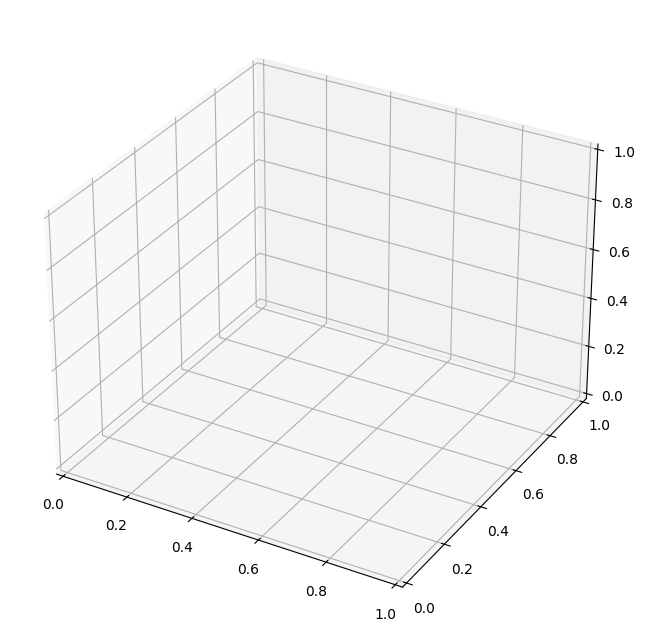

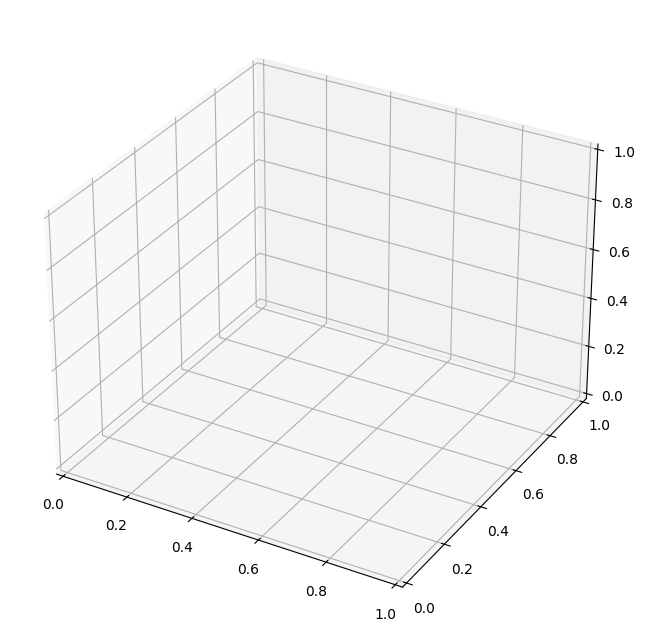

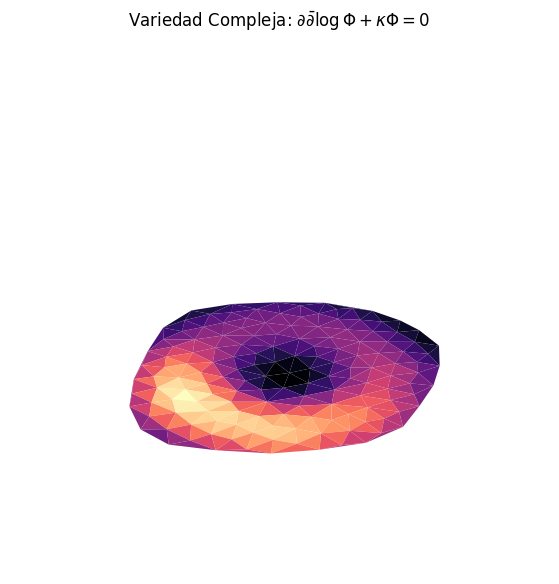

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.spatial import Delaunay

def run_safe_liouville():
    # 1. Configuración de parámetros
    n_nodes = 150
    pos = np.random.uniform(-1.5, 1.5, (n_nodes, 2))
    u = np.zeros(n_nodes)
    v = np.zeros(n_nodes)
    dt = 0.02
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    def update(frame):
        nonlocal pos, u, v
        t = frame * 0.1
        
        try:
            # A. Triangulación y Laplaciano Robusto
            tri = Delaunay(pos)
            lap_u = np.zeros(n_nodes)
            counts = np.zeros(n_nodes)
            for s in tri.simplices:
                for j in range(3):
                    n1, n2 = s[j], s[(j+1)%3]
                    diff = u[n2] - u[n1]
                    lap_u[n1] += diff
                    lap_u[n2] -= diff
                    counts[n1] += 1; counts[n2] += 1
            lap_u /= (counts + 1e-6)

            # B. Dinámica de Liouville con LIMITADORES (evita NaN)
            k = 2.0 * np.exp(-np.sum((pos - [np.cos(t), np.sin(t)])**2, axis=1) / 0.3)
            # Clip: u no puede pasar de 2.0, evitando el overflow de exp(u)
            u_clipped = np.clip(u, -4, 2) 
            aceleracion = (0.3 * lap_u) + 0.4 * k * np.exp(u_clipped)
            
            v = (v + aceleracion * dt) * 0.95 # Fricción
            u += v * dt

            # C. Repulsión de Nodos
            forces = np.zeros_like(pos)
            for s in tri.simplices:
                for j in range(3):
                    n1, n2 = s[j], s[(j+1)%3]
                    vec = pos[n2] - pos[n1]
                    dist = np.linalg.norm(vec) + 1e-6
                    target = 0.2 * np.exp(np.clip(u[n1], -0.5, 0.5))
                    f = 0.05 * (dist - target)
                    forces[n1] += f * (vec / dist)
                    forces[n2] -= f * (vec / dist)
            pos += forces
            pos = np.clip(pos, -2.5, 2.5)

            # D. Dibujo
            ax.clear()
            ax.plot_trisurf(pos[:, 0], pos[:, 1], u, triangles=tri.simplices, 
                            cmap='magma', edgecolor='none', antialiased=True)
            ax.set_zlim(-0.5, 3.5)
            ax.set_axis_off()
            ax.set_title(r"Variedad Compleja: $\partial\bar{\partial} \log \Phi + \kappa \Phi = 0$")
            ax.view_init(elev=30, azim=frame)

        except Exception as e:
            print(f"Error en simulación: {e}")

    # Crear Animación
    ani = FuncAnimation(fig, update, frames=100, interval=50)
    
    # GUARDAR COMO GIF (No requiere ffmpeg)
    print("Guardando animación como liouville.gif... espera un momento.")
    ani.save("liouville.gif", writer=PillowWriter(fps=20))
    plt.show()

if __name__ == "__main__":
    run_safe_liouville()


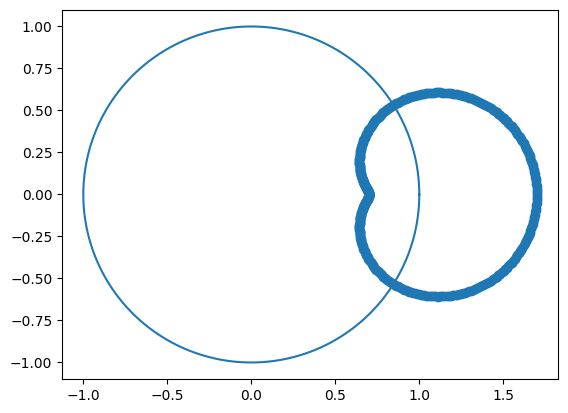

In [12]:
def section_O_n(z, coeffs):
    # p(z) = a_0 + a_1 z + ... + a_n z^n
    return sum(c*z**k for k, c in enumerate(coeffs))

z_vals = np.exp(1j*np.linspace(0,2*np.pi,400))
vals = section_O_n(z_vals, [1, -0.5, 0.2])

plt.plot(z_vals.real, z_vals.imag)
plt.scatter(vals.real, vals.imag)
plt.axis("equal")
plt.show()


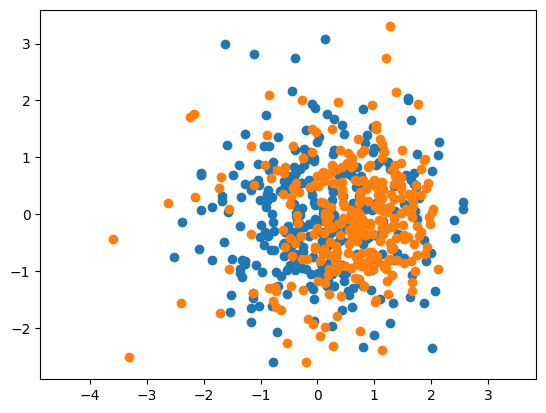

In [13]:
def mobius(z, a, b, c, d):
    return (a*z + b)/(c*z + d)

z = np.random.randn(300) + 1j*np.random.randn(300)
z2 = mobius(z, 1, 0.5, 0.2, 1)

plt.scatter(z.real, z.imag)
plt.scatter(z2.real, z2.imag)
plt.axis("equal")
plt.show()
